<a href="https://colab.research.google.com/github/YorkJong/Colab/blob/main/ViStock_BullRun_Drawdown.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Visualizing Stock Indicators of BullRun and Drawdown


## Install Required Packages

In [1]:
%pip install git+https://github.com/YorkJong/vistock.git

  Cloning https://github.com/YorkJong/vistock.git to /tmp/pip-req-build-4so7wt1l
  Running command git clone --filter=blob:none --quiet https://github.com/YorkJong/vistock.git /tmp/pip-req-build-4so7wt1l
  Resolved https://github.com/YorkJong/vistock.git to commit a19d2801ee174e3ded03320ffd1c29a136eac37d
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 3.8 MB/s eta 0:00:00
  Created wheel for vistock: filename=vistock-0.3.0-py3-none-any.whl size=24338 sha256=f917668596369d4e482b5e19f4edced0ee0e028b962b6cf067c29efcb879f047
  Stored in directory: /tmp/pip-ephem-wheel-cache-49726rz3/wheels/11/d0/ab/74a0ef21cb422317e943a3f7a0788132f3fce8f3fcd683438f
Successfully built vistock


## Chatrs

### Functions to calculate Bull Run and Drawdown indicator

In [2]:
import pandas as pd
import numpy as np


def calculate_bull_run(df):
    """
    Calculate the bull-run for each 'Close' price in the dataframe.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing stock data with a 'Close' column.

    Returns
    -------
    pandas.Series
        Series representing the bull-run values.
    """
    df['Daily_Return'] = df['Close'].pct_change()
    df['Cumulative_Return'] = (1 + df['Daily_Return']).cumprod()
    df['Drawdown'] = df['Cumulative_Return'] / df['Cumulative_Return'].cummax() - 1
    drawdown_threshold = np.percentile(df['Drawdown'].dropna(), 80)

    bull_run = 0
    max_price = df['Close'].iloc[0]
    bull_runs = []

    for price, returns in zip(df['Close'], df['Daily_Return']):
        if price > max_price:
            max_price = price

        if returns > 0:
            bull_run += returns
        elif (max_price - price) / max_price > drawdown_threshold:
            bull_run = 0
            max_price = price

        bull_runs.append(bull_run)

    return bull_runs


def calculate_rolling_drawdown(data, window=60):
    """
    Calculate the rolling drawdown for each price in the dataframe.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing stock data with a 'High', 'Close' columns.
    window: int
        window size to rolling.

    Returns
    -------
    pandas.Series
        Series representing the rolling drawdown values.
    """
    rolling_max = data['High'].rolling(window=window, min_periods=1).max()
    drawdown = (data['Close'] - rolling_max) / rolling_max
    return drawdown


def calculate_drawdown(df):
    """
    Calculate the drawdown for each price in the dataframe.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing stock data with a 'High', 'Close' columns.

    Returns
    -------
    pandas.Series
        Series representing the drawdown values.
    """
    peak = df['High'].expanding(min_periods=1).max()
    drawdown = (df['Close'] - peak) / peak
    return drawdown

'''
def calculate_drawdown(df):
    """
    Calculate the drawdown for each price in the dataframe.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing stock data with a 'Close' column.

    Returns
    -------
    pandas.Series
        Series representing the drawdown values.
    """
    peak = df['Close'].expanding(min_periods=1).max()
    drawdown = (df['Close'] - peak) / peak
    return drawdown
'''

'\ndef calculate_drawdown(df):\n    """\n    Calculate the drawdown for each price in the dataframe.\n\n    Parameters\n    ----------\n    df : pandas.DataFrame\n        DataFrame containing stock data with a \'Close\' column.\n\n    Returns\n    -------\n    pandas.Series\n        Series representing the drawdown values.\n    """\n    peak = df[\'Close\'].expanding(min_periods=1).max()\n    drawdown = (df[\'Close\'] - peak) / peak\n    return drawdown\n'

### Show a stock chart with Bull Run and Drawdown indicator (using mplfinance)

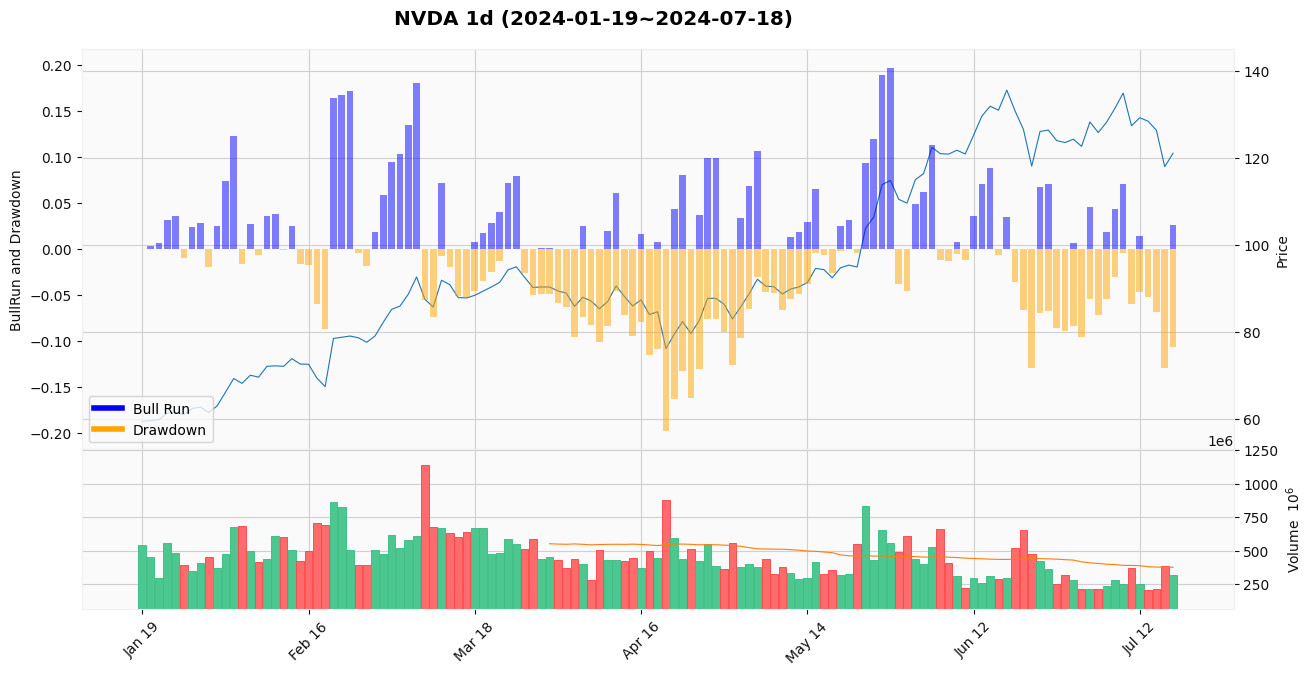

In [3]:
import yfinance as yf
import matplotlib.pyplot as plt
import mplfinance as mpf
from matplotlib.lines import Line2D
from vistock import tw


def show_bullrun_drawdown_mpl(
        ticker='TSLA', period='1y', interval='1d', legend_loc='best'):
    """Visualize bull run and drawdown indicators on a stock price chart.

    This function downloads stock data for the specified ticker and period,
    calculates the drawdown and bull run indicators, and visualizes them using
    mplfinance.

    Parameters
    ----------
    ticker
        the ticker name (default is 'TSLA')
    period
        the period (default is '1y' that means 1 year)
    interval
        the interval (default is '1d' that means 1 day)
    legend_loc
        the location of the legend (default is 'best')
        Valid locations are
            best
            upper right
            upper left
            lower left
            lower right
            right
            center left
            center right
            lower center
            upper center
            center
    """
    # Download stock data
    ticker = tw.as_yfinance(ticker)
    df = yf.Ticker(ticker).history(period=period, interval=interval)

    # Calculate drawdown and bull run
    df['Drawdown'] = calculate_drawdown(df)
    df['BullRun'] = calculate_bull_run(df)

    # Add Bull Run and Drawdown indicators
    bull_run_addplot = mpf.make_addplot(
        df['BullRun'], type='bar', color='blue', alpha=0.5,
        panel=0, secondary_y=True, ylabel='BullRun and Drawdown')
    drawdown_addplot = mpf.make_addplot(
        df['Drawdown'], type='bar', color='orange', alpha=0.5,
        panel=0, secondary_y=True)

    # Add Volume Moving Average
    vma = mpf.make_addplot(
        df['Volume'], mav=50,
        type='line', linestyle='',
        panel=1)

    # Plot candlesticks price, bull-run, drawdown, volume, and volume MA
    fig, axes = mpf.plot(
        df, type='line',
        volume=True, addplot=[bull_run_addplot, drawdown_addplot, vma],
        style='yahoo', figsize=(16, 8),
        returnfig=True
    )

    # Move indicators y-axis to the left and price & volume y-axis to the right
    for ax in axes:
        if ax.get_ylabel() == 'BullRun and Drawdown':
            ax.yaxis.tick_left()
            ax.yaxis.set_label_position("left")
        else:
            ax.yaxis.tick_right()
            ax.yaxis.set_label_position("right")

    # Plot legend
    legend = [
        Line2D([0], [0], color='blue', lw=4, label='Bull Run'),
        Line2D([0], [0], color='orange', lw=4, label='Drawdown'),
    ]
    axes[0].legend(handles=legend, loc=legend_loc)

    # Convert datetime index to string format suitable for display
    if interval.endswith('m') or interval.endswith('h'):
        df.index = df.index.strftime('%Y-%m-%d %H:%M')
    else:
        df.index = df.index.strftime('%Y-%m-%d')
    fig.suptitle(
        f"{ticker} {interval} ({df.index.values[0]}~{df.index.values[-1]})",
        y=0.93)

    # Show
    mpf.show()  # plt.show()


if __name__ == '__main__':
    symbol = "NVDA" #@param ["NVDA", "TSLA", "MSFT", "AAPL", "GOOG", "TQQQ", "SOXL", "TSM", "台積電", "2330", "元太", "BTC-USD", "ETH-USD"] {allow-input: true}
    period = "6mo" #@param ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max']
    interval = '1d' #@param ['1m', '2m', '5m', '15m', '30m', '60m', '90m', '1h', '1d', '5d', '1wk', '1mo', '3mo']
    legend_loc = "lower left" #@param ["best", "upper right", "upper left", "lower left", "lower right", "right", "center left", "center right", "lower center", "upper center", "center"]
    show_bullrun_drawdown_mpl(
        ticker=symbol, period=period, interval=interval, legend_loc=legend_loc)

### Show a stock chart with Bull Run and Drawdown indicator (using Plotly)

In [4]:
symbol = "TSLA" #@param ["NVDA", "TSLA", "MSFT", "META", "AAPL", "GOOG", "TQQQ", "SOXL", "TSM", "台積電", "2330", "元太", "BTC-USD", "ETH-USD"] {allow-input: true}
period = "1y" #@param ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max']
interval = '1d' #@param ['1m', '2m', '5m', '15m', '30m', '60m', '90m', '1h', '1d', '5d', '1wk', '1mo', '3mo']

"""
Show a stock chart with price, bull-run and drawdown indicator, and volume.
* Data from yfinance
* Plot with Plotly
"""
import yfinance as yf
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import vistock.plotly.fig_util as futil
from vistock import tw

# Download stock data
ticker = tw.as_yfinance(symbol)
df = yf.Ticker(ticker).history(period=period, interval=interval)

# Initialize empty plot with a marginal subplot
#fig = go.Figure(layout=go.Layout(height=720))
#fig = go.Figure()
# Initialize empty plot with a marginal subplot
fig = make_subplots(
    rows=2, cols=1,
    row_heights=[0.7, 0.3],
    #shared_xaxes=True,
    vertical_spacing=0.03,
    specs=[
        [{"secondary_y": True}],    # row 1, col 1
        [{"secondary_y": False}]    # row 2, col 1
    ],
    figure=go.Figure(layout=go.Layout(height=720))
)

# Add moving averages to the figure
price = go.Scatter(x=df.index, y=df['Close'], name=f'Price',
            line=dict(color='brown', width=2), yaxis='y2'
        )
fig.add_trace(price)

# Add bull-run trace to the figure
df['BullRun'] = calculate_bull_run(df)
drawdown = go.Bar(x=df.index, y=df['BullRun'], name='BullRun',
                marker_color='blue', opacity=0.5)
fig.add_trace(drawdown)

# Add drawdown trace to the figure
df['Drawdown'] = calculate_drawdown(df)
drawdown = go.Bar(x=df.index, y=df['Drawdown'], name='Drawdown',
                marker_color='orange', opacity=0.5)
fig.add_trace(drawdown)

# Add close-high diff trace to the figure
df['Close-High'] = (df['Close'] - df['High']) / df['Close']
diff = go.Bar(x=df.index, y=df['Close-High'], name='Close-High',
                marker_color='red', opacity=0.5)
fig.add_trace(diff)

# Add close-low diff trace to the figure
df['Close-Low'] = (df['Close'] - df['Low']) / df['Close']
diff = go.Bar(x=df.index, y=df['Close-Low'], name='Close-Low',
              marker_color='green', opacity=0.5)
fig.add_trace(diff)

fig.update_layout(barmode='overlay')

# Add volume trace to 2nd row
colors = ['green' if c - o >= 0
          else 'red' for o, c in zip(df['Open'], df['Close'])]
volume = go.Bar(x=df.index, y=df['Volume'], name='Volume',
                marker_color=colors, opacity=0.5)
fig.add_trace(volume, row=2, col=1)

# Add moving average volume to 2nd row
df['vma50'] = df['Volume'].rolling(window=50).mean()
vma50 = go.Scatter(x=df.index, y=df['vma50'], name='VMA 50',
                   line=dict(color='purple', width=2))
fig.add_trace(vma50, row=2, col=1)

# Convert datetime index to string format suitable for display
if interval.endswith('m') or interval.endswith('h'):
    df.index = df.index.strftime('%Y-%m-%d %H:%M')
else:
    df.index = df.index.strftime('%Y-%m-%d')

# Update layout
fig.update_layout(
    title=f'{ticker} {interval} ({df.index.values[0]}~{df.index.values[-1]})',
    title_x=0.5, title_y=.9,

    xaxis=dict(anchor='free'),
    yaxis=dict(title='Indicators', side='left', anchor='x3'),
    yaxis2=dict(title='Price (USD)', side='right', anchor='x3'),
    yaxis3=dict(title='Volume', side='right'),

    legend=dict(yanchor='middle', y=0.5, xanchor="left", x=0.01),
    xaxis_rangeslider_visible=False,
    xaxis2_rangeslider_visible=False,
)

futil.hide_nontrading_periods(fig, df, interval)

# For Crosshair cursor
futil.add_crosshair_cursor(fig)
futil.add_hovermode_menu(fig)


# Show the figure
fig.show()


### Show a stock Volume Profile (2 split; using Plotly)

In [5]:
kind = "Turnover Profile with 2 Subplots" #@param ["Volume Profile with 2 Subplots", "Turnover Profile with 2 Subplots", "Volume Profile with 4 Subplots", "Turnover Profile with 4 Subplots"]
symbol = "TSLA" #@param ["NVDA", "TSLA", "MSFT", "AAPL", "GOOG", "TQQQ", "SOXL", "TSM", "台積電", "2330", "元太", "BTC-USD", "ETH-USD"] {allow-input: true}
period = "1y" #@param ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max']
interval = '1d' #@param ['1m', '2m', '5m', '15m', '30m', '60m', '90m', '1h', '1d', '5d', '1wk', '1mo', '3mo']
total_bins = 42 #@param ["8", "28", "33", "42", "58", "69"] {type:"raw", allow-input: true}
hides_nontrading = True #@param {type:"boolean"}
hbar_align_on_right = False #@param {type:"boolean"}

import vistock.plotly as vsp

tbl = {
    #'Price and Volume Overlaid': vsp.pv1s,
    #'Price and Volume Separated': vsp.pv2s,
    'Volume Profile with 2 Subplots': vsp.prf2s.Volume,
    'Turnover Profile with 2 Subplots': vsp.prf2s.Turnover,
    'Volume Profile with 4 Subplots': vsp.prf4s.Volume,
    'Turnover Profile with 4 Subplots': vsp.prf4s.Turnover,
}

module = tbl[kind]
if kind.endswith('2 Subplots'):
    module.plot(symbol, period=period, interval=interval, total_bins=total_bins,
                hides_nontrading=hides_nontrading,
                hbar_align_on_right=hbar_align_on_right)
elif kind.endswith('4 Subplots'):
    module.plot(symbol, period=period, interval=interval, total_bins=total_bins,
                hides_nontrading=hides_nontrading)

## Test

In [6]:
display(df)
#display(fig)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Daily_Return,Cumulative_Return,Drawdown,BullRun,Close-High,Close-Low,vma50
Date,,,,,,,,,,,,,,
2023-07-19,296.040009,299.290009,289.519989,291.260010,142355400,0.0,0.0,NaN,NaN,-0.026830,0.000000,-0.027570,0.005974,NaN
2023-07-20,279.559998,280.929993,261.200012,262.899994,175158300,0.0,0.0,-0.097370,0.902630,-0.121588,0.000000,-0.068581,0.006466,NaN
2023-07-21,268.000000,268.000000,255.800003,260.019989,161050100,0.0,0.0,-0.010955,0.892742,-0.131211,0.000000,-0.030690,0.016229,NaN
2023-07-24,255.850006,269.850006,254.119995,269.059998,136508500,0.0,0.0,0.034767,0.923779,-0.101006,0.034767,-0.002936,0.055527,NaN
2023-07-25,272.380005,272.899994,265.000000,265.279999,112757300,0.0,0.0,-0.014049,0.910801,-0.113636,0.000000,-0.028724,0.001055,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-12,235.800003,251.839996,233.089996,248.229996,155694400,0.0,0.0,0.029872,0.852263,-0.170604,0.029872,-0.014543,0.060992,91207436.0
2024-07-15,255.970001,265.600006,251.729996,252.639999,146912900,0.0,0.0,0.017766,0.867404,-0.155869,0.047638,-0.051298,0.003602,92289100.0
2024-07-16,255.309998,258.619995,245.800003,256.559998,126332500,0.0,0.0,0.015516,0.880862,-0.142771,0.063154,-0.008029,0.041939,93032790.0


In [7]:
from vistock import tw

display(tw.similar_stocks('數位'))
#display(tw.as_yfinance("台積電"))

[('國泰數位支付服務', '00909')]